In [1]:
#%pip install -U tbparse
#%pip install -U tqdm
#%pip install -U matplotlib

In [2]:
%load_ext tensorboard
import pandas as pd
from tbparse import SummaryReader
from pathlib import PureWindowsPath, PurePosixPath
import tqdm
import matplotlib.pyplot as plt

In [3]:
#%tensorboard --logdir 'd:\\pretrainer-2\model_runs\\after jigsaw SR with HNSCC_test'
%tensorboard --logdir '/mnt/d/model_runs2024/model_runs/pretrain-2025-05-04-06_16_46'

In [4]:
log_dir = '/mnt/d/pretrainer-3/model_runs/2021-05-20-14_48_45/logs'
reader = SummaryReader(log_dir)
df = reader.scalars
print(df)

     step            tag     value
0      49          epoch  0.000000
1      99          epoch  0.000000
2     149          epoch  0.000000
3     199          epoch  0.000000
4     249          epoch  0.000000
..    ...            ...       ...
245  2839  val_loss_mean  0.428144
246  3407  val_loss_mean  0.436634
247  3975  val_loss_mean  0.419287
248  4543  val_loss_mean  0.408870
249  5111  val_loss_mean  0.402166

[250 rows x 3 columns]


In [5]:
class RunResults():
    ''' extracts:
    1. test DICE loss
    2. training loss per epoch
    3. validation loss per epoch
    4. number of epochs
    '''
    def __init__(self, df, folder):
        self.folder = folder
        self.set_test_loss(df)
        self.set_training_epoch_loss(df)
        self.set_val_epoch_loss(df)
        self.set_n_epochs(df)

    def set_test_loss(self, df):
        try:
            self.test_loss = df.loc[df['tag'] == 'test_loss_mean']['value']
        except KeyError:
            self.test_loss = None

    def set_n_epochs(self, df):
        try:
            self.n_epochs = len(df.loc[df['tag'] == 'train_loss_epoch'])
        except KeyError:
            self.n_epochs = None

    def set_training_epoch_loss(self, df):
        try:
            self.training_epoch_loss = df.loc[df['tag'] == 'train_loss_epoch']['value'] #pandas series
        except KeyError:
            self.training_epoch_loss = None

    def set_val_epoch_loss(self, df):
        try:
            self.val_epoch_loss = df.loc[df['tag'] == 'val_loss_mean']['value'] #pandas series
            if len(self.val_epoch_loss) == 0:
                self.val_epoch_loss = df.loc[df['tag'] == 'validation_loss']['value'] #pandas series
        except KeyError:
            self.val_epoch_loss = None

In [6]:
class ResultCollection():
    def __init__(self, folder_list, windows = True, prefix = "D:\\"):
        self.windows = windows
        self.prefix = prefix

        folder_list = list(map(self.convert_to_local_path, folder_list))

        self.folders = folder_list
        self.results = {}
        for folder in tqdm.tqdm(self.folders):
            reader = SummaryReader(folder)
            df = reader.scalars
            self.results[folder] = RunResults(df, folder)

    def summary_table(self):
        cols = ["folder", "n_epochs", "final_train_loss", "final_val_loss", "test_loss", "test_DICE"]
        df = pd.DataFrame(columns=cols)

        i = 0
        for result in self.results.values():
            #try:
                #final_train_loss = result.training_epoch_loss.iloc[-1] <- original code. failed when the given attribute did not exist. so over-ridden by function below
            final_train_loss = ResultCollection.get_if_not_none(result.training_epoch_loss)
            final_val_loss = ResultCollection.get_if_not_none(result.val_epoch_loss)
            test_loss = ResultCollection.get_if_not_none(result.test_loss)    # to get a numeric value instead of series of 1 number
            df.loc[i] = [result.folder, result.n_epochs, final_train_loss, final_val_loss, test_loss, 1 - test_loss]

            #except IndexError as e:
            #    print("Error: missing data for folder %s \n" % result.folder)
            i += 1

        return df

    @staticmethod
    def get_if_not_none(var):
        if var is None or len(var) == 0:
            return -1
        else:
            return var.iloc[-1]
    
    def summary_loss_per_epoch(self):
        training_losses = {}
        val_losses = {}

        for result in self.results.values():
            training_losses[result.folder] = result.training_epoch_loss
            val_losses[result.folder] = result.val_epoch_loss

        return (training_losses, val_losses)
    
    def loss_per_epoch(self, folder):
        folder = self.convert_to_local_path(folder)

        result = self.results[folder]
        return result.training_epoch_loss, result.val_epoch_loss

    def convert_to_local_path(self, input_path):
        if self.windows:
            if not input_path.lower().startswith(self.prefix):
                windows_path = PureWindowsPath(self.prefix, input_path)
            else:
                windows_path = PureWindowsPath(input_path)
            return str(windows_path)
        
        else:
            if input_path.startswith(self.prefix):
                return str(PurePosixPath(input_path))
            else:
                return str(PurePosixPath(self.prefix, input_path))
    

    


In [7]:
folders_list = '''pretrainer/model_runs/2021-05-16-22_06_42
pretrainer/model_runs/2021-05-17-03_53_06
pretrainer/model_runs/2021-05-17-22_39_14
pretrainer/model_runs/2021-05-18-01_02_44
pretrainer/model_runs/2021-05-18-03_36_21
pretrainer/model_runs/2021-05-20-13_28_30
pretrainer/model_runs/2021-05-20-14_48_37
pretrainer/model_runs/2021-05-20-15_50_38
pretrainer/model_runs/2021-05-20-15_54_17
pretrainer/model_runs/2021-05-30-00_16_58
pretrainer/model_runs/2021-05-30-00_19_57
pretrainer/model_runs/2021-05-30-01_39_40
pretrainer/model_runs/2021-05-31-19_17_23
pretrainer/model_runs/2021-06-02-00_28_12
pretrainer/model_runs/2021-06-02-02_43_34
pretrainer/model_runs/2021-06-07-11_20_52
pretrainer/model_runs/2021-06-08-00_45_45
pretrainer/model_runs/best_model
pretrainer/model_runs/finetuning_01
pretrainer/model_runs/finetuning_02
pretrainer/model_runs/imagenet_segpretrain
pretrainer/model_runs/quarter_imagenet
pretrainer/model_runs/random_nopretrain_nooptim
pretrainer-2/model_runs/2021-05-18-03_11_13
pretrainer-2/model_runs/2021-05-19-15_14_53
pretrainer-2/model_runs/2021-05-20-13_32_29
pretrainer-2/model_runs/2021-05-20-14_48_41
pretrainer-2/model_runs/2021-05-20-15_50_34
pretrainer-2/model_runs/2021-05-20-15_54_20
pretrainer-2/model_runs/2021-05-30-00_20_18
pretrainer-2/model_runs/2021-05-30-01_39_37
pretrainer-2/model_runs/2021-05-31-00_20_52
pretrainer-2/model_runs/2021-05-31-17_34_04
pretrainer-2/model_runs/2021-06-02-00_36_31
pretrainer-2/model_runs/2021-06-02-02_37_06
pretrainer-2/model_runs/2021-06-07-00_15_33
pretrainer-2/model_runs/2021-06-07-02_00_45
pretrainer-2/model_runs/after jigsaw SR with HNSCC_test
pretrainer-2/model_runs/fine_tuning_after_pre2
pretrainer-2/model_runs/random_segpretrain
pretrainer-2/model_runs/random_segpretrain_nooptim
pretrainer-3/model_runs/2021-05-19-22_03_42
pretrainer-3/model_runs/2021-05-20-13_28_53
pretrainer-3/model_runs/2021-05-20-14_48_45
pretrainer-3/model_runs/2021-05-20-15_50_29
pretrainer-3/model_runs/2021-05-20-15_54_22
pretrainer-3/model_runs/2021-05-31-17_33_57
pretrainer-3/model_runs/2021-06-01-14_59_18
pretrainer-3/model_runs/2021-06-01-15_05_32
pretrainer-3/model_runs/imagenet_segpretrain_nooptim
pretrainer-4/model_runs/2021-05-19-22_03_46
pretrainer-4/model_runs/2021-05-20-13_28_57
pretrainer-4/model_runs/2021-05-20-14_48_48
pretrainer-4/model_runs/2021-05-20-15_50_25
pretrainer-4/model_runs/2021-05-31-17_33_47
pretrainer-4/model_runs/2021-06-01-15_05_37
pretrainer-4/model_runs/imagenet_nopretrain
trained_models/1 - resenet34 frozen encoder
trained_models/10 - 100_epochs_resnet34_encoder_10_frozen
trained_models/100_epochs_16_features_unet
trained_models/100_epochs_32_features_unet
trained_models/100_epochs_4_features_unet
trained_models/100_epochs_8_features_unet
trained_models/100_epochs_resnet34_encoder_frozen_fast
trained_models/100_epochs_resnet34_encoder_frozen_slow
trained_models/100_epochs_resnet34_encoder_nonfrozen_slowish_1
trained_models/100_epochs_resnet34_encoder_nonfrozen_slowish_2
trained_models/100_epochs_resnet34_imagenet_7_frozen
trained_models/100_epochs_resnet34_imagenet_8_frozen
trained_models/11 - 100_epochs_resnet34_encoder_8_frozen_slow
trained_models/12 - 100_epochs_resnet34_encoder_4_frozen_really_slow
trained_models/13 - 100_epochs_resnet34_encoder_3_frozen_slow
trained_models/14 - 100_epochs_resnet34_encoder_nonfrozen_single_slice
trained_models/15 - 100_epochs_resnet34_encoder_nonfrozen_single_slice_from_3_diff_slices
trained_models/2 - frozen_same_image_3_channels
trained_models/20_epochs_no_scheduler
trained_models/3 - 100_epochs_resnet34_encoder_8_frozen_3_slices
trained_models/4 - 100_epochs_resnet34_nonfrozen_slowish
trained_models/5 - 100_epochs_resnet34_encoder_random_weights
trained_models/6 - 100_epochs_resnet34_encoder_nonfrozen_random_weights_slow
trained_models/7 - 100_epochs_resnet34_encoder_4_frozen_flow
trained_models/8 - 100_epochs_resnet34_encoder_6_frozen
trained_models/9 - 100_epochs_resnet34_encoder_4_frozen
trained_models/frozen_same_image_3_channels
trained_models/stolen_finetuned_1e-3
model_runs2024/model_runs/2024-11-17-19_13_59
model_runs2024/model_runs/2025-04-09-04_28_03
model_runs2024/model_runs/2025-04-09-08_56_30
model_runs2024/model_runs/2025-04-09-21_52_45
model_runs2024/model_runs/pretrain-2025-04-09-18_14_22
pretrainer/model_runs/pretrain-2021-05-19-03_26_56
pretrainer/model_runs/pretrain-2021-05-19-03_27_05
pretrainer/model_runs/pretrain-2021-05-29-05_35_22
pretrainer/model_runs/pretrain-2021-05-29-05_35_27
pretrainer/model_runs/pretrain-2021-05-29-05_35_30
pretrainer/model_runs/pretrain-2021-05-29-15_26_31
pretrainer/model_runs/pretrain-2021-05-29-15_26_36
pretrainer/model_runs/pretrain-2021-05-29-15_26_39
pretrainer/model_runs/pretrain-2021-05-29-18_33_49
pretrainer/model_runs/pretrain-2021-05-29-18_33_54
pretrainer/model_runs/pretrain-2021-05-29-18_33_57
pretrainer/model_runs/pretrain-2021-05-30-17_54_38
pretrainer/model_runs/pretrained_jigsaw_resnet34
pretrainer/model_runs/pretrain_jigsaw_fixed2_random
pretrainer/model_runs/pretrain_jigsaw_fixed_random
pretrainer/model_runs/pretrain_segmentation_imagenet
pretrainer/model_runs/pretrain_segmentation_imagenet_small
pretrainer/model_runs/pretrain_segmentation_random
pretrainer-2/model_runs/ennead_jigsaw_1000_large
pretrainer-2/model_runs/pretrain-2021-05-19-03_33_09
pretrainer-2/model_runs/pretrain-2021-05-19-03_34_49
pretrainer-2/model_runs/pretrain-2021-05-19-04_28_59
pretrainer-2/model_runs/pretrain-2021-05-20-16_14_19
pretrainer-2/model_runs/pretrain-2021-05-29-05_35_50
pretrainer-2/model_runs/pretrain-2021-05-29-05_35_56
pretrainer-2/model_runs/pretrain-2021-05-29-05_35_59
pretrainer-2/model_runs/pretrain-2021-05-29-15_25_52
pretrainer-2/model_runs/pretrain-2021-05-29-15_25_57
pretrainer-2/model_runs/pretrain-2021-05-29-15_26_00
pretrainer-2/model_runs/pretrain-2021-05-29-18_34_25
pretrainer-2/model_runs/pretrain-2021-05-29-18_34_30
pretrainer-2/model_runs/pretrain-2021-05-29-18_34_33
pretrainer-2/model_runs/pretrain_2
pretrainer-2/model_runs/pretrain_jigsaw_fixed2_imagenet
pretrainer-2/model_runs/pretrain_jigsaw_fixed_imagenet
pretrainer-2/model_runs/pretrain_segmentation_imagenet
pretrainer-2/model_runs/pretrain_segmentation_random
pretrainer-2/model_runs/pretrain_segmentation_random_small
pretrainer-3/model_runs/pretrain-2021-05-30-21_13_42
pretrainer-3/model_runs/pretrain_segmentation_imagenet
pretrainer-3/model_runs/pretrain_segmentation_random
pretrainer-4/model_runs/pretrain-2021-05-30-21_15_55
pretrainer-4/model_runs/pretrain_segmentation_imagenet
pretrainer-4/model_runs/pretrain_segmentation_random
pretrainer-5/model_runs/pretrain_segmentation_imagenet
pretrainer-5/model_runs/pretrain_segmentation_random
thesis/model_runs/CORRUPTED_pretrain_segmentation_imagenet
thesis/model_runs/CORRUPTED_pretrain_segmentation_random
thesis/model_runs/pretrain-2021-05-20-00:59:15
thesis/model_runs/pretrain-2021-05-20-01:06:07
thesis/model_runs/pretrain-2021-05-20-01:07:22
thesis/model_runs/pretrain-2021-05-20-01:08:16
thesis/model_runs/pretrain-2021-05-20-01:09:05
thesis/model_runs/pretrain-2021-05-29-01:04:21
thesis/model_runs/pretrain-2021-05-29-01:07:45
thesis/model_runs/pretrain-2021-05-29-11:18:56
thesis/model_runs/pretrain-2021-05-29-14:00:13
thesis/model_runs/pretrain-2021-05-29-14:18:59
thesis/model_runs/pretrain-2021-05-29-21:18:04
thesis/model_runs/pretrain-2021-05-30-10:51:30
thesis/model_runs/pretrain-2021-05-30-11:08:24
thesis/model_runs/pretrain-2021-05-30-14:16:19
thesis/model_runs/pretrain-2021-05-30-21:39:00
thesis/model_runs/pretrain-2021-05-30-21:41:32
thesis/model_runs/pretrain-2021-05-30-21:47:41
thesis/model_runs/pretrain-2021-05-30-21:49:33
thesis/model_runs/pretrained_jigsaw_resnet34
thesis/model_runs/pretrain_segmentation_imagenet
thesis/model_runs/pretrain_segmentation_imagenet_small
thesis/model_runs/pretrain_segmentation_random
thesis/model_runs/pretrain_segmentation_random_small
model_runs2024/model_runs/2025-04-11-00_30_35
model_runs2024/model_runs/2025-04-11-05_50_40
model_runs2024/model_runs/2025-04-11-17_37_37
model_runs2024/model_runs/2025-04-11-22_02_39
model_runs2024/model_runs/2025-04-12-00_25_00
model_runs2024/model_runs/2025-04-13-19_29_08
model_runs2024/model_runs/pretrain-2025-04-11-05_15_35
model_runs2024/model_runs/pretrain-2025-04-11-07_08_26
model_runs2024/model_runs/pretrain-2025-04-11-07_10_29
model_runs2024/model_runs/pretrain-2025-04-09-18_14_22
model_runs2024/model_runs/pretrain-2025-04-10-21_09_23
model_runs2024/model_runs/pretrain-2025-04-11-18_39_17
model_runs2024/model_runs/pretrain-2025-04-11-20_29_05
model_runs2024/model_runs/pretrain-2025-05-04-06_15_25
model_runs2024/model_runs/pretrain-2025-05-04-06_16_46
model_runs2024/model_runs/2025-05-04-21_14_39
model_runs2024/model_runs/2025-05-04-22_28_59'''.split("\n")



In [8]:
rc = ResultCollection(folders_list, windows=False, prefix="/mnt/d/")

df = rc.summary_table()

training_losses, val_losses = rc.summary_loss_per_epoch()

  0%|          | 0/178 [00:00<?, ?it/s]

100%|██████████| 178/178 [01:08<00:00,  2.60it/s]


In [9]:
list(training_losses.values())[0]

1340    0.613249
1341    0.364743
1342    0.329897
1343    0.318731
1344    0.302591
          ...   
1435    0.133374
1436    0.134171
1437    0.136439
1438    0.135754
1439    0.135462
Name: value, Length: 100, dtype: float64

In [10]:
def plot_series(series1, series2, series3, label, series1_label ="", series2_label = "", series3_label = "", savesvg_path = None, y_label = "Loss (1 - DICE)", x_label = "Epoch", save_svgs = True):
    ''' series1 and series2 are dictionaries with keys beying result folders and values being numeric loss values'''
    # Plot the points
    plt.plot(range(len(series1)), series1, '-', label=series1_label, linestyle="-.") 
    plt.plot(range(len(series2)), series2, '-', label=series2_label) 

    if series3 is not None:
        plt.plot(range(len(series3)), series3, '-', label=series3_label) 

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(label)
    plt.legend()

    if save_svgs and savesvg_path:
        plt.savefig(savesvg_path, format="svg")

    # Display the plot
    plt.show()

In [11]:
# random_loss_per_epoch pretrainer/model_runs/random_nopretrain_nooptim
# imagenet_loss_per_epoch model_runs2024/model_runs/2024-11-17-19_13_59
# jigsaw pretrain imagenet model_runs2024/model_runs/pretrain-2025-04-11-18_39_17      Loss per epoch - Jigsaw pretraining 

Imagenet
| Label | SVG | Folder | DICE |
|:--------:|:--------:|:--------:|:--------:|
|  Loss per epoch - Jigsaw pretraining (imagenet)   |  jigsaw_loss_per_epoch.svg   |  model_runs2024/model_runs/pretrain-2025-04-11-18_39_17   |  False  |
|  Loss per epoch - JigsawSR pretraining (imagenet)   |  jigsaw_sr_loss_per_epoch.svg   |  model_runs2024/model_runs/pretrain-2025-04-11-20_29_05   |  False  |
|  Loss per epoch - Segmentation pretraining (imagenet)  |  segmentation_loss_per_epoch.svg   |  model_runs2024/model_runs/pretrain-2025-05-04-06_16_46   |  True  |

Random
| Label | SVG | Folder | DICE |
|:--------:|:--------:|:--------:|:--------:|
|  Loss per epoch - Jigsaw pretraining (random)  |  jigsaw_loss_per_epoch_random.svg   |  model_runs2024/model_runs/pretrain-2025-04-10-21_09_23   |  False  |
|  Loss per epoch - JigsawSR pretraining (random)  |  jigsaw_sr_loss_per_epoch_random.svg   |  model_runs2024/model_runs/pretrain-2025-04-09-18_14_22   |  False  |
|  Loss per epoch - Segmentation pretraining (random)  |  segmentation_loss_per_epoch_random.svg   |  model_runs2024/model_runs/pretrain-2025-05-04-06_15_25   |  True  |

/tmp/ipykernel_8846/438915044.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(len(series1)), series1, '-', label=series1_label, linestyle="-.")


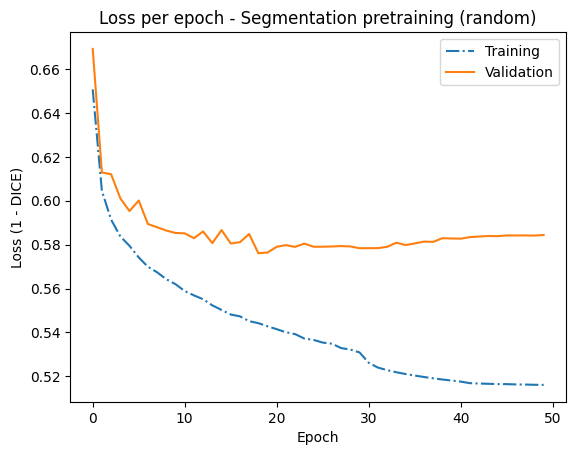

In [12]:
save_svgs = False

is_dice = True
label = "Loss per epoch - Segmentation pretraining (random)"
svg = "segmentation_loss_per_epoch_random.svg"
result_folder = "model_runs2024/model_runs/pretrain-2025-05-04-06_15_25"


training_loss, val_loss = rc.loss_per_epoch(result_folder)

if is_dice:
    training_loss = training_loss + 1
    val_loss = val_loss + 1
    y_label = "Loss (1 - DICE)"
else:
    y_label = "Loss (cross entropy)"

plot_series(training_loss, val_loss, None, label, 
            series1_label="Training", series2_label="Validation",
            savesvg_path="/mnt/c/Users/Hussam/Documents/Masters thesis/Result graphs/" + svg,
            save_svgs=save_svgs, y_label=y_label)

/tmp/ipykernel_8846/438915044.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(len(series1)), series1, '-', label=series1_label, linestyle="-.")


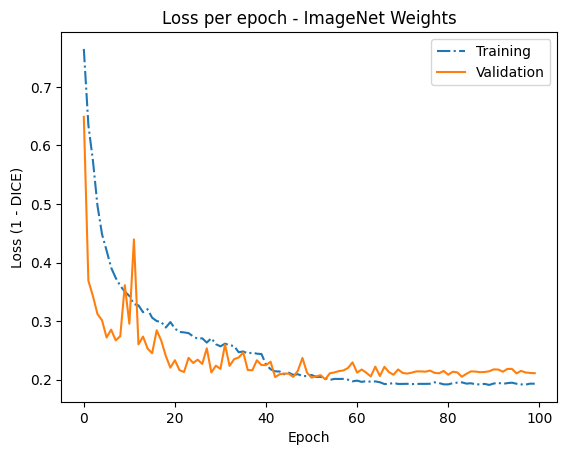

In [13]:
result_folder = "pretrainer/model_runs/2021-05-31-19_17_23"

training_loss, val_loss = rc.loss_per_epoch(result_folder)

plot_series(training_loss, val_loss, None, "Loss per epoch - ImageNet Weights", 
            series1_label="Training", series2_label="Validation",
            savesvg_path="C:\\Users\\Hussam\\Documents\\Masters thesis\\Result graphs\\imagenet_loss_per_epoch.svg", save_svgs=False)